## Seminar 5: Deep Networks

# Imports

In [1]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import cPickle as pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy.misc import imread, imsave, imresize
from lasagne.utils import floatX
import cv2
from sklearn.feature_extraction import DictVectorizer
from sklearn.cross_validation import train_test_split
import pandas as pd
import time

Using gpu device 0: GeForce GTX 970 (CNMeM is disabled, cuDNN 4007)


In [3]:
from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.nonlinearities import rectify, softmax

IMAGE_W = 224

#vgg19 model
#http://www.robots.ox.ac.uk/~vgg/research/very_deep/
def build_model():
    net = {}
    net['input'] = InputLayer((None, 3, 224, 224))
    net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_4'] = ConvLayer(net['conv3_3'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_4'], 2)
    net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['conv4_4'] = ConvLayer(net['conv4_3'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_4'], 2)
    net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['conv5_4'] = ConvLayer(net['conv5_3'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_4'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    #net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
    net['fc7'] = DenseLayer(net['fc6'], num_units=4096)
    net['fc7_dropout'] = DropoutLayer(net['fc7'], p=0.5)
    net['fc8'] = DenseLayer(net['fc7_dropout'], num_units=1000, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)
    return net

In [4]:
#classes' names are stored here
classes = pickle.load(open('classes.pkl'))
#for example, 10th class is ostrich:
print classes[9]

ostrich, Struthio camelus


You have to implement two functions in the cell below.

Preprocess function should take the image with shape (w, h, 3) and transform it into a tensor with shape (1, 3, 224, 224). Without this transformation, vgg19 won't be able to digest input image. 
Additionally, your preprocessing function have to rearrange channels RGB -> BGR and subtract mean values from every channel.

In [5]:
MEAN_VALUES = np.array([104, 117, 123], dtype='float32')
IMAGE_W = 224

def preprocess(img):
    t_img = np.zeros((1, 3, IMAGE_W, IMAGE_W), dtype='float32')
    t_img[0,0,:,:] = cv2.resize(img[:,:,2], (IMAGE_W, IMAGE_W)) - MEAN_VALUES[0]
    t_img[0,1,:,:] = cv2.resize(img[:,:,1], (IMAGE_W, IMAGE_W)) - MEAN_VALUES[1]
    t_img[0,2,:,:] = cv2.resize(img[:,:,0], (IMAGE_W, IMAGE_W)) - MEAN_VALUES[2]
    return floatX(t_img)

def deprocess(t_img):
    img = np.zeros((IMAGE_W, IMAGE_W, 3), dtype='float32')
    img[:,:,0] = cv2.resize(t_img[0,2,:,:], (IMAGE_W, IMAGE_W)) + MEAN_VALUES[2]
    img[:,:,1] = cv2.resize(t_img[0,1,:,:], (IMAGE_W, IMAGE_W)) + MEAN_VALUES[1]
    img[:,:,2] = cv2.resize(t_img[0,0,:,:], (IMAGE_W, IMAGE_W)) + MEAN_VALUES[0]
    return floatX(img)

img = np.random.rand(IMAGE_W, IMAGE_W, 3)

print np.linalg.norm(deprocess(preprocess(img)) - img)

0.000854863264394


If your implementation is correct, the number above will be small, because deprocess function is the inverse of preprocess function

In [6]:
#load model weights
#vgg19.npz is available for download at
#https://yadi.sk/d/UQPXeM_GqEmGg
net = build_model()
params = np.load('vgg19.npz')['params']
for i in xrange(32,len(params)):
    params[i] = params[i].T
lasagne.layers.set_all_param_values(net.values(), params)

In [6]:
input_image = T.tensor4('input')
output = lasagne.layers.get_output(net['prob'], input_image, deterministic=True)
prob = theano.function([input_image], output) 

In the cell below, you can test your preprocessing function on some sample images. If it is implemented correctly, **albatross.jpg** will be classified as albatross with 99.9% certainty, and with other pictures the network will produce mostly meaningful result.

You can notice that network output varies from run to run. This behaviour can be supressed with help of "deterministic" keyword in get_output function in the cell above.

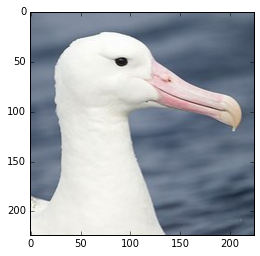

top-5 classes are:
0.998435	albatross
0.001543	goose
0.000007	American egret
0.000006	ptarmigan
0.000002	American coot


In [7]:
img = imread('sample_images/albatross.jpg')
plt.imshow(img)
plt.show()

p = prob(preprocess(img))

labels = p.ravel().argsort()[-1:-6:-1]
print 'top-5 classes are:'
for l in labels:
    print '%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0])

Now, use vgg19 network and your knowledge of machine learning to classify cats and dogs!

data: https://yadi.sk/d/m6ZO4BvWqEmR9

**catsvsdogs/val/** validation images

**catsvsdogs/val_labels.pickle** labels for validation images, sorted by filename

**catsvsdogs/test/** test images

You have to implement classification algorithm, tune it on validation images, save output of your algorithm on test images in form of pickled file, as shown below. Your results, as well as this notebook, have to be attached to your letter to rdlclass@yandex.ru

I expect classification accuracy >95%, or >90% at least

Cheating is not allowed

In [7]:
def iterate_minibatches(X, y, batchsize):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_ind in range(0, len(X) - batchsize +1, batchsize):
        excerpt = indices[start_ind:start_ind + batchsize]
        yield X[excerpt], y[excerpt]

In [8]:
net['prob'] = DenseLayer(net['fc7'], num_units = 2, nonlinearity = lasagne.nonlinearities.softmax)

In [9]:
input_X = T.tensor4('input')
target_y = T.matrix("target Y integer",dtype='int32')

#network prediction (theano-transformation)
y_predicted = lasagne.layers.get_output(net['prob'], input_X)

#all network weights (shared variables)
all_weights = lasagne.layers.get_all_params(net['prob'], trainable=True)

#network loss
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()

#network accuaracy
accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#gradient descent form
updates = lasagne.updates.adagrad(loss, all_weights, learning_rate=1e-4, epsilon=1e-6)

In [10]:
#A function that accepts X and y, returns loss functions and performs weight updates
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates=updates)

#A function that just computes accuracy given X and y
accuracy_fun = theano.function([input_X,target_y],accuracy)

#A function that computes probabilities given X
prob_fun = theano.function([input_X], y_predicted) 

In [11]:
#features = lasagne.layers.get_output(net['fc8'], input_X)
#extract_features = theano.function([input_X], features)

path = 'catsvsdogs/val/'
files = sorted(os.listdir(path))
X = []
for f in files:
    img = imread(path + f)
    X.append(preprocess(img)[0,:,:,:])
    
X = np.array(X)
y = np.array(pickle.load(open("catsvsdogs/val_labels.pickle", "rb")))

dv = DictVectorizer(sparse=False) 
df = pd.DataFrame(y)
y = dv.fit_transform(df.to_dict(orient='records'))
y = np.array(y, dtype='int32')

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0)

In [12]:
num_epochs = 15

batch_size = 5

for epoch in xrange(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    #val_acc = 0
    #val_batches = 0
    #for batch in iterate_minibatches(X_val, y_val, batch_size):
        #inputs, targets = batch
        #val_acc += accuracy_fun(inputs, targets)
        #val_batches += 1

    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    #print("  validation accuracy:\t\t{:.2f} %".format(
        #val_acc / val_batches * 100))

Epoch 1 of 15 took 10.057s
  training loss (in-iteration):		0.619352
  train accuracy:		76.00 %
Epoch 2 of 15 took 10.107s
  training loss (in-iteration):		0.020872
  train accuracy:		99.00 %
Epoch 3 of 15 took 10.101s
  training loss (in-iteration):		0.000460
  train accuracy:		100.00 %
Epoch 4 of 15 took 10.085s
  training loss (in-iteration):		0.000296
  train accuracy:		100.00 %
Epoch 5 of 15 took 10.091s
  training loss (in-iteration):		0.000227
  train accuracy:		100.00 %
Epoch 6 of 15 took 10.205s
  training loss (in-iteration):		0.000187
  train accuracy:		100.00 %
Epoch 7 of 15 took 10.148s
  training loss (in-iteration):		0.000159
  train accuracy:		100.00 %
Epoch 8 of 15 took 10.137s
  training loss (in-iteration):		0.000139
  train accuracy:		100.00 %
Epoch 9 of 15 took 10.132s
  training loss (in-iteration):		0.000123
  train accuracy:		100.00 %
Epoch 10 of 15 took 10.128s
  training loss (in-iteration):		0.000110
  train accuracy:		100.00 %
Epoch 11 of 15 took 10.151s
  t

In [13]:
def classify(img):
    
    x = preprocess(img)
    p = prob_fun(x)
    
    if (p[0,0]>p[0,1]):
        return 'cat'
    else:
        return 'dog'

In [14]:
path = 'catsvsdogs/test/'
files = sorted(os.listdir(path))

labels = []

for f in files:
    img = imread(path + f)
    label = classify(img)
    labels.append(label)
    
pickle.dump(labels, open('test_labels.pickle', 'wb'))

In [15]:
report = pd.DataFrame({'image_id':range(400), 'label':labels})
report.to_csv('submission.csv', index=False)

## Visualizations

It is easy to visualize the weights of the first convolutional layer:

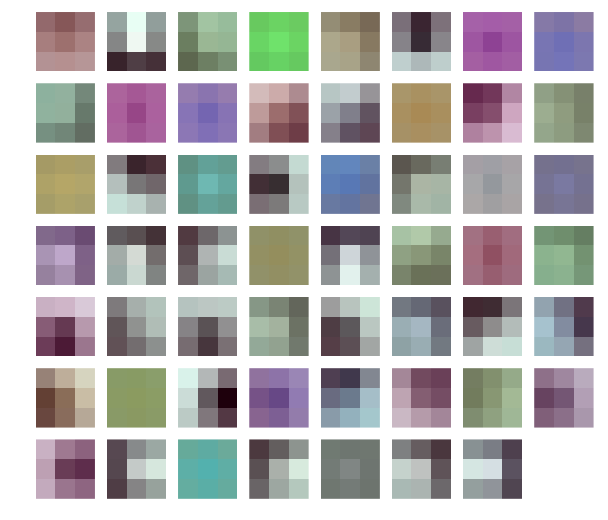

In [16]:
w = np.array(net['conv1_1'].W.eval().copy())
w -= w.min()
w /= w.max()
plt.figure(figsize=(10, 10))
for i in xrange(1, 9):
    for j in xrange(1, 9):
        n = 8*j + i
        if n < 64:
            plt.subplot(8,8,n)
            plt.axis('off')
            plt.imshow(w[n,:,:,:].transpose((1,2,0)), interpolation='none')
plt.show()

On higher layers, filters have more than 3 channels, so it is impossible to visualize them directly. However, of we want to understand something about features on higher layers, it is possible to visualize them via optimization of the input image.

Namely, we can solve the following problem

$$J=\mathrm{argmax} \left( n^i_{xyc}(I) \right)$$

there $n^i_{xyc}$ is the activation of neuron on $i$'th layer in position $x$,$y$,$c$ given input image $I$.
Basically, $J$ is the answer on a question "what our neuron is looking for?"

In [17]:
generated_image = theano.shared(floatX(np.zeros((1, 3, IMAGE_W, IMAGE_W))))
gen_features = lasagne.layers.get_output(net.values(), generated_image)
gen_features = {k: v for k, v in zip(net.keys(), gen_features)}

layer_name = 'pool1'
c = 0
blob_width = gen_features[layer_name].shape[2]
x = blob_width/2
y = blob_width/2
activation_loss = 1e10*(1e1 - gen_features[layer_name][0, c, x, y])**2

tv_loss = T.mean(T.abs_(generated_image[:,:,1:,1:] - generated_image[:,:,:-1,1:]) +
                 T.abs_(generated_image[:,:,1:,1:] - generated_image[:,:,1:,:-1]))

loss = activation_loss + 1.0 * tv_loss

grad = T.grad(loss, generated_image)

f_loss = theano.function([], loss)
f_grad = theano.function([], grad)

# Helper functions to interface with scipy.optimize
def eval_loss(x0):
    x_ = floatX(x0.reshape((1, 3, IMAGE_W, IMAGE_W)))
    generated_image.set_value(x_)
    return f_loss().astype('float64')

def eval_grad(x0):
    x0 = floatX(x0.reshape((1, 3, IMAGE_W, IMAGE_W)))
    generated_image.set_value(x0)
    return np.array(f_grad()).flatten().astype('float64')

/home/user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.
/home/user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: Division of two integer types with x / y is deprecated, please use x // y for an integer division.


In [18]:
#run input image optimization via scipy.optimize.fmin_l_bfgs_b
generated_image.set_value(floatX(np.zeros((1, 3, IMAGE_W, IMAGE_W))))
x0 = generated_image.get_value().astype('float64')
status = scipy.optimize.fmin_l_bfgs_b(eval_loss, x0.flatten(), fprime=eval_grad, maxfun=20)
x0 = generated_image.get_value().astype('float64')

If your **deprocess** function is implemented correctly, you'll see that the neuron on the first pooling layer is looking for. The result should look like gabor filter, simular to ones found in the first layer of networks with large filters, such as AlexNet.

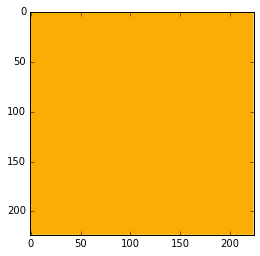

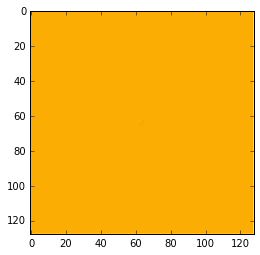

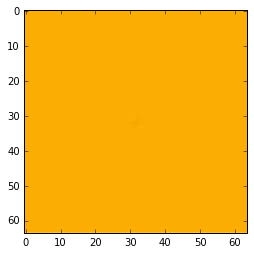

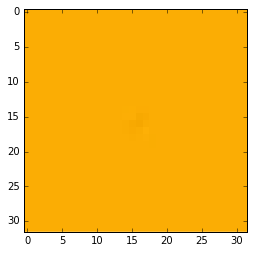

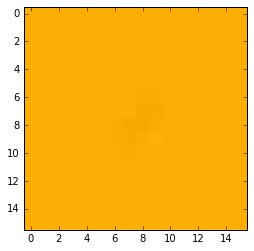

In [19]:
#show the results
w = IMAGE_W
for d in [112, 64, 32, 16, 8]:
    pic = deprocess(x0)[w/2-d:w/2+d,w/2-d:w/2+d,:]
    pic -= pic.min()
    pic /= pic.max()
    plt.imshow(pic, interpolation='None')
    plt.show()

Optional problem:
Adjust the code above to work with neurons on fc8 layer.


fc8 neurons are wired to output classes, so maximization of neuron value will produce an image which contains as much of given class (from the point of view of neural network) as possible. 

Examples of such images are shown at:

http://yosinski.com/deepvis

http://googleresearch.blogspot.ru/2015/06/inceptionism-going-deeper-into-neural.html

http://auduno.com/post/125362849838/visualizing-googlenet-classes

https://317070.github.io/Dream/